# Timeseries

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Loading the data

In [45]:
df_emp=pd.read_pickle("emp_dfpkl.sec")

In [46]:
df_emp.head()

,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1990-01-01,12.4,177.3,218.4,1988.5,169.7,305.1,42.6,521.3,524.9,21.0,...,32.5,502.7,938.9,101.6,44.2,391.3,337.7,81.7,524.5,8.9
1990-02-01,12.4,177.6,218.9,1988.7,170.0,304.8,46.7,519.9,526.9,21.0,...,32.8,503.8,939.4,101.9,43.7,391.0,337.4,82.0,527.9,8.8
1990-03-01,12.9,177.1,217.8,1986.3,170.3,304.5,46.9,517.8,528.2,21.0,...,33.1,504.0,940.7,101.9,43.4,391.6,338.6,82.4,526.8,9.1
1990-04-01,13.7,176.5,219.0,1987.8,171.1,304.8,46.7,513.4,529.4,20.6,...,32.8,503.9,942.1,104.1,43.0,390.6,337.2,82.7,525.1,9.0
1990-05-01,14.5,176.7,219.2,1984.4,170.4,302.9,46.7,513.2,527.5,20.4,...,33.4,504.7,940.6,104.1,43.2,389.1,336.4,82.6,525.3,9.1


We are only interested in 5 states: OHIO, TEXAS; MICHIGAN; INDIANA anf CALIFORNIA

In [47]:
df_emp= df_emp[['Michigan','California','Ohio','Texas','Indiana']]

Ploting the differnece states

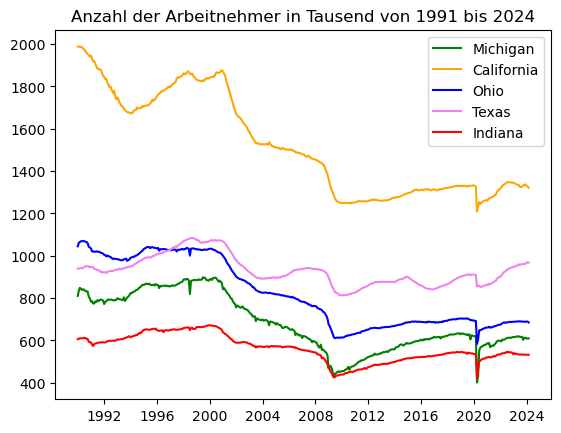

In [48]:
plt.plot(df_emp['Michigan'], label='Michigan', color='green')
plt.plot(df_emp['California'], label='California', color='orange')
plt.plot(df_emp['Ohio'], label='Ohio', color='blue')
plt.plot(df_emp['Texas'], label='Texas', color='violet')
plt.plot(df_emp['Indiana'], label='Indiana', color='red')
plt.title('Anzahl der Arbeitnehmer in Tausend von 1991 bis 2024')

plt.legend()

plt.show()

Weitere Begrenzung der Daten

In [49]:
emp_final= df_emp[238:] #-> nur noch daten nach der Finanzkrise 

Im weiteren Verlauf werden wir Zeitreihen vorhersagen machen mit jedem er 5 States 

In [50]:
ohio=emp_final['Ohio']
texas=emp_final['Texas']
california=emp_final['California']
michigan=emp_final['Michigan']
indiana=emp_final['Indiana']

## Texas

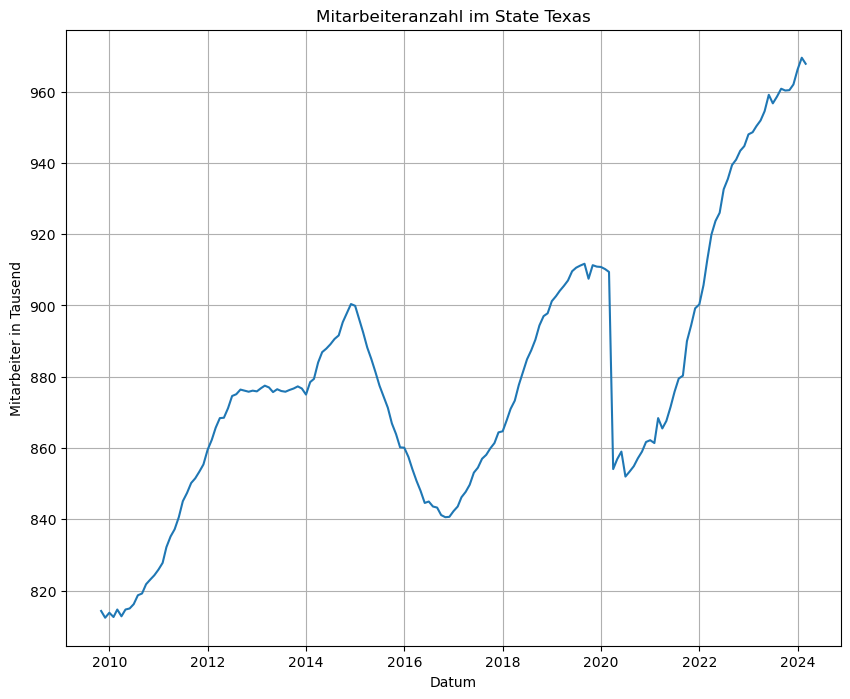

In [51]:
plt.figure(figsize=(10, 8))
plt.plot(texas)
plt.title('Mitarbeiteranzahl im State Texas')
plt.xlabel('Datum')
plt.ylabel('Mitarbeiter in Tausend')
plt.grid(True)
plt.show()

In [52]:
#Test und Traingsdaten
train = texas[:int(0.9 * len(texas))]
test = texas[int(0.9 * len(texas)):]

In [53]:
print(f"Länge des Trainingsdatensatzes: {len(train)}")
print(f"Länge des Testdatensatzes: {len(test)}")


Länge des Trainingsdatensatzes: 155
Länge des Testdatensatzes: 18


## 1. Zeitreihen Analyse: Gleitender durschschnitt

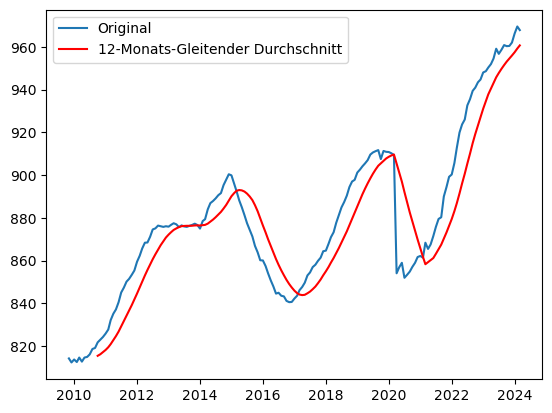

In [54]:
MA = texas.rolling(window=12).mean()
plt.plot(texas, label='Original')
plt.plot(MA, label='12-Monats-Gleitender Durchschnitt', color='red')
plt.legend()
plt.show()

Der gleitende durschnitt glättetSchwankungen im Graph ab um leichter Trends abzulesen

#### Saisonale Zerlegung

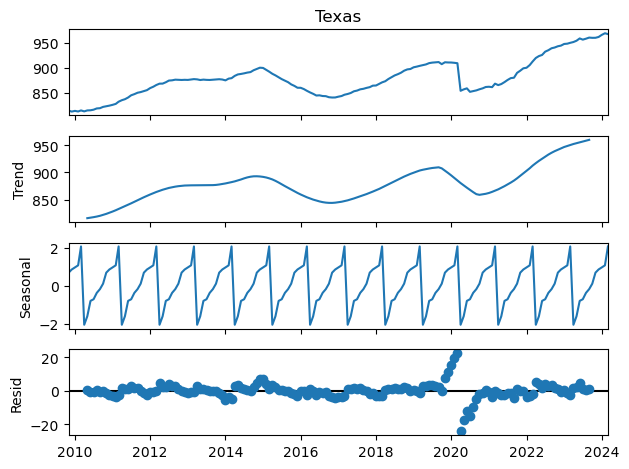

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(texas, model='additive')
result.plot()
plt.show()

man erkennt einen Trend und saisonalität in der Zeitreieh, die im späteren Verlauf 'gelöscht' werden muss


#### Herstellung von Saisonalität durch differnezieren

Durch die Visualisierung hat man schon Trends und Saisonalität erkannt, aber um 100 prozent sicher zu sein kann man den Dickey Fuller test anwenden.

der p- Value muss < 0.05 sein -> dann ist eine Zeitreihe stationär

In [56]:
result = adfuller(texas)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -1.0655122896277553
p-value: 0.728627493504266


nicht stationär, also muss man es stationär machen durch differenzierung 

In [57]:
texas_diff= texas.diff().dropna()

Plot der differnzierten Funktion

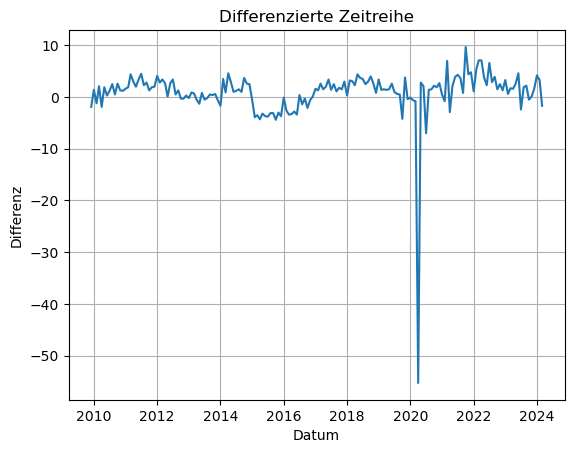

In [58]:
plt.plot(texas_diff)
plt.title('Differenzierte Zeitreihe')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.grid(True)
plt.show()

In [59]:
result = adfuller(texas_diff)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -5.186460701538381
p-value: 9.369259295332538e-06


Jetzt noch die saisonalität rausnehmen mit dem 12 MA


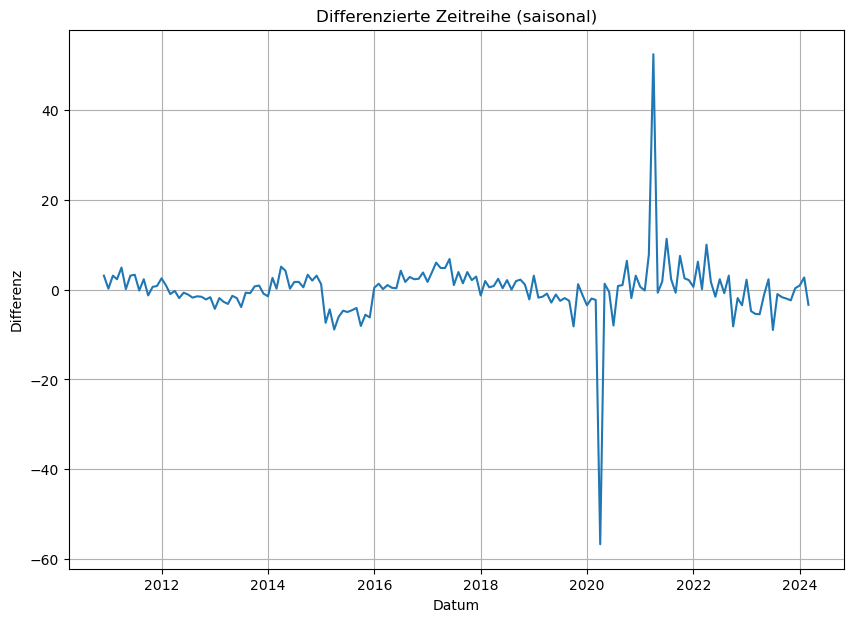

In [60]:
t2_diff= texas_diff.diff(12).dropna()
plt.figure(figsize=(10, 7))
plt.plot(t2_diff)
plt.title('Differenzierte Zeitreihe (saisonal)')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.grid(True)
plt.show()

In [61]:
result = adfuller(t2_diff)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -4.752481163584066
p-value: 6.698893477232903e-05


# SARIMA Model Times Series

Setzt sich zusammen aus Arima (AR, Differenzierung, Moving Average) und dem Saisonalen Faktor

#### Vorgehen:
1. Lags für Ar, I, MA finden durch ACF, PACF und Differenzierung


## 1. AR -> Autoregression


Um AR machen zu können muss man wissen wie viele lags man nimmt, also der Zusammenhang eines Wertes mit einem bestimmten Wert 

#### PACF: Partielle Autokorrelation

In [62]:
from statsmodels.graphics.tsaplots import plot_pacf

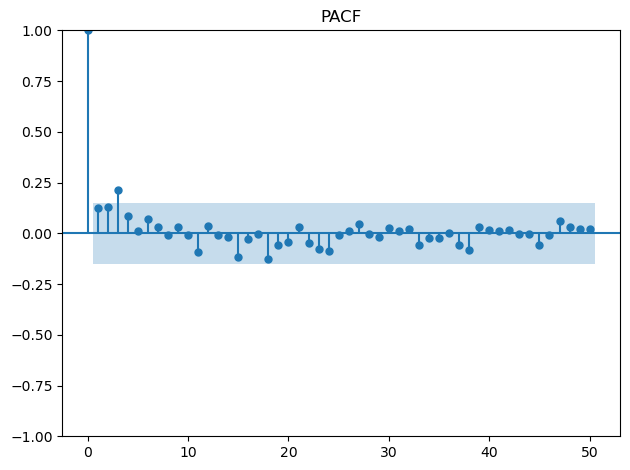

In [63]:
plot_pacf(texas_diff,lags=50,title='PACF')
plt.tight_layout()
plt.show()

Optimale Anzahl der lags: 3

In [36]:
#from statsmodels.tsa.ar_model import AutoReg, ar_select_order



In [67]:
from statsmodels.tsa.arima.model import ARIMA

In [68]:
model=  ARIMA(train, order=(3,0,0))
model_fit = model.fit()
# MA gleich 0 weil wir nur die AR komponente betrachten

In [70]:
print(model_fit.summary())
#excluding lags
# prediction: pred_start= test.index[0] pred_end= test.index[-1]

                               SARIMAX Results                                
Dep. Variable:                  Texas   No. Observations:                  155
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -476.610
Date:                Sat, 05 Oct 2024   AIC                            963.220
Time:                        01:36:02   BIC                            978.437
Sample:                    11-01-2009   HQIC                           969.401
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        873.8004     43.091     20.278      0.000     789.344     958.257
ar.L1          1.1231      0.053     21.186      0.000       1.019       1.227
ar.L2          0.0213      0.066      0.324      0.7

Betrachtung der P werte um signifikante lags herauszufinden

In [71]:
pred_start= test.index[0]
pred_end= test.index[-1]

In [73]:
pred=model_fit.predict(start=pred_start, end= pred_end)

In [74]:
residuals=test-pred

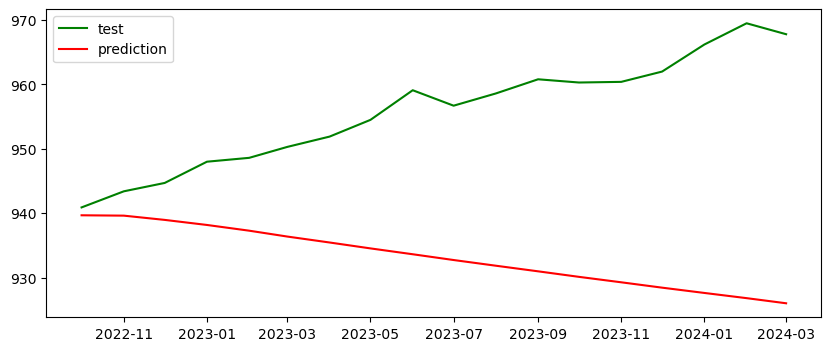

In [80]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( pred, label='prediction',color='red')
plt.legend()
plt.show()

Evaluation: Prediction und Test sind sehr verschieden

In [82]:
print('MSE', round(np.mean(abs(residuals/test)),4))

MSE 0.0235


In [83]:
print('RMSE', np.sqrt(np.mean(residuals**2)))

RMSE 25.853032737327574


### ARIMA

Die einfachste Vorgehensweise ist der Auto ARIMA ansatz

In [50]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [51]:
from pmdarima import auto_arima

In [52]:
fit= auto_arima(texas_diff, trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1038.688, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1044.678, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1044.006, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1044.499, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1048.106, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1037.314, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1045.011, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1037.048, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1037.730, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1043.161, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1036.362, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1046.914, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1046.081, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1037.032, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]          

In [54]:
my_order = (1,0,1)
my_sorder = (0,0,0,0)

auto_arima = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
auto_model = auto_arima.fit()
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Texas   No. Observations:                  155
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -481.875
Date:                Tue, 24 Sep 2024   AIC                            969.750
Time:                        03:47:53   BIC                            978.881
Sample:                    11-01-2009   HQIC                           973.459
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   3120.841      0.000       0.999       1.001
ma.L1          0.1191      0.052      2.278      0.023       0.017       0.221
sigma2        27.4865      0.562     48.932      0.0

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [55]:
pred= auto_model.predict(start=len(train),end=len(train)+ len(test) - 1)

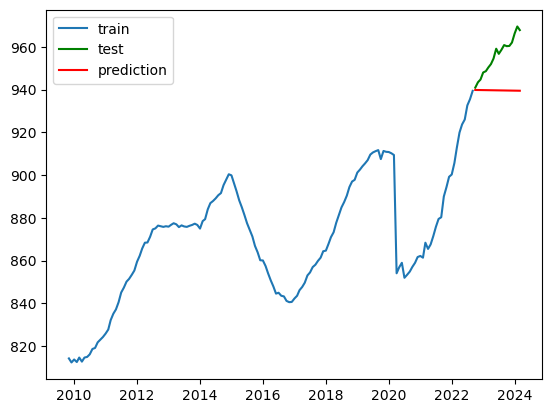

In [56]:
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test',color='green')
plt.plot(test.index, pred, label='prediction',color='red')
plt.legend()
plt.show()

## SARIMAX ausgeführt

In [86]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf


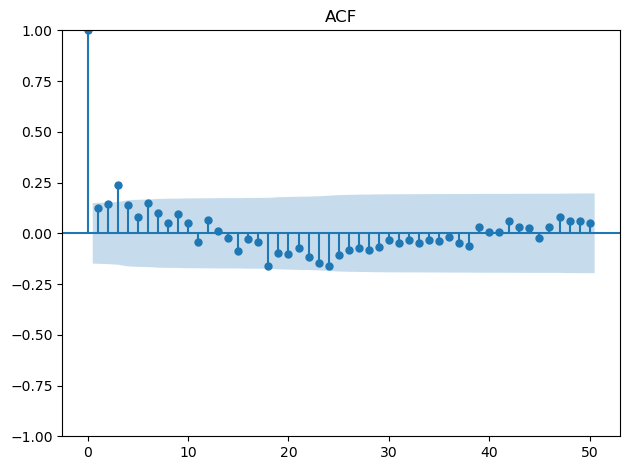

In [88]:
plot_acf(texas_diff, lags=50,title='ACF')
plt.tight_layout()
plt.show()

In [89]:
my_order = (3,1,3)
my_sorder = (1,1,1,12)

modell = SARIMAX(train, order=my_order, seasonal_order=my_sorder)

modell_fit = modell.fit()

# Modell anzeigen
print(modell_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Texas   No. Observations:                  155
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -443.825
Date:                              Sat, 05 Oct 2024   AIC                            905.651
Time:                                      02:20:01   BIC                            932.253
Sample:                                  11-01-2009   HQIC                           916.461
                                       - 09-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2792      0.408      0.684      0.494      -0.520       1.079
ar.L2         -0.31

In [91]:
s_pred=modell_fit.predict(start=pred_start,end= pred_end)

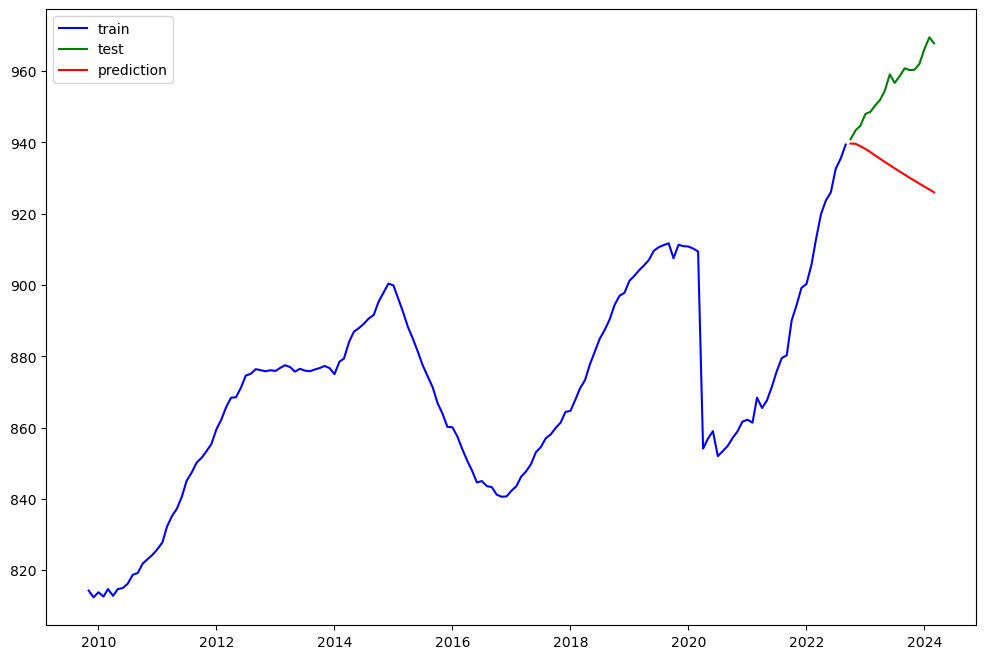

In [93]:
plt.figure(figsize=(12,8))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( pred, label='prediction',color='red')
plt.legend()
plt.show()